In [28]:
from cil.framework import  AcquisitionGeometry, ImageData

from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D, show_geometry
from cil.utilities import noise

import matplotlib.pyplot as plt

import numpy as np

In [29]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

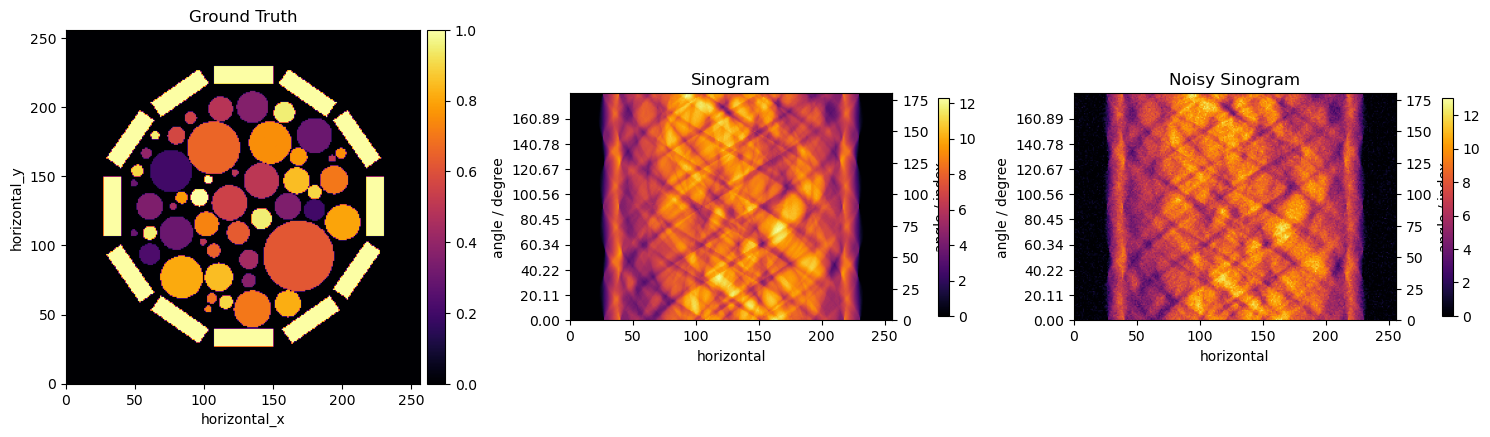

In [30]:
# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'cpu')

# Create an acquisition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title = ['Ground Truth','Sinogram','Noisy Sinogram'], num_cols=3, cmap = 'inferno')

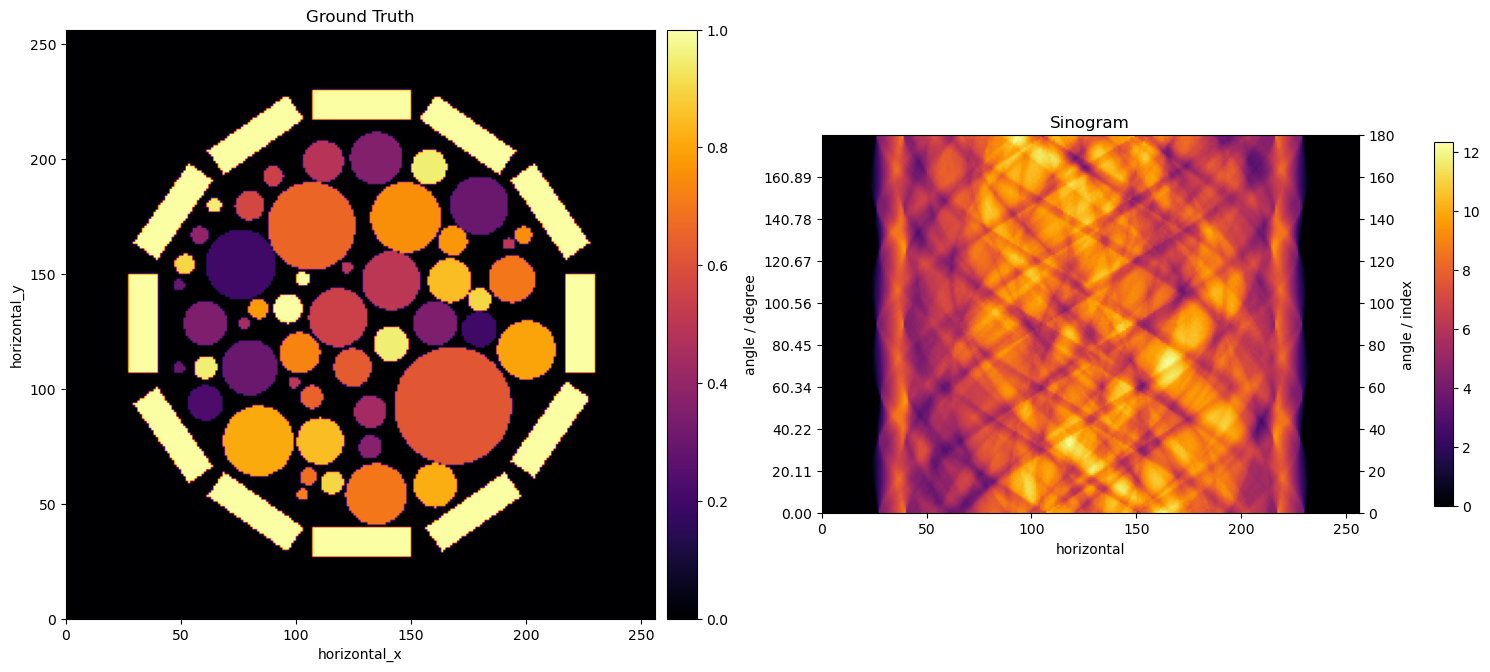

Saved image as e:\天天\undergraduate\3rd year\Project\example_sino1.png


<Figure size 640x480 with 0 Axes>

In [31]:
sinogram = show2D([phantom, sino], title = ['Ground Truth','Sinogram'], num_cols=2, cmap = 'inferno')
sinogram.save('example_sino1.png')

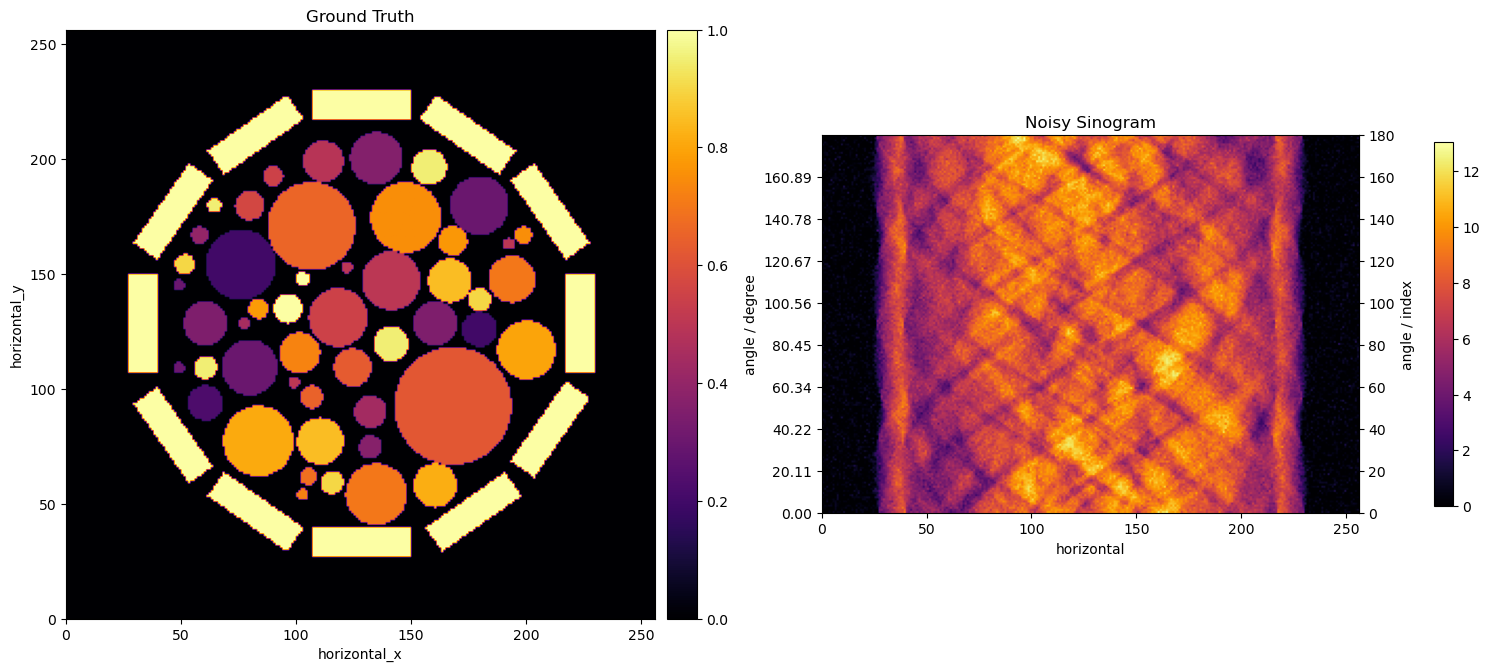

Saved image as e:\天天\undergraduate\3rd year\Project\example_sino2.png


<Figure size 640x480 with 0 Axes>

In [32]:
sinogram1 = show2D([phantom, noisy_sino], title = ['Ground Truth','Noisy Sinogram'], num_cols=2, cmap = 'inferno')
sinogram1.save('example_sino2.png')

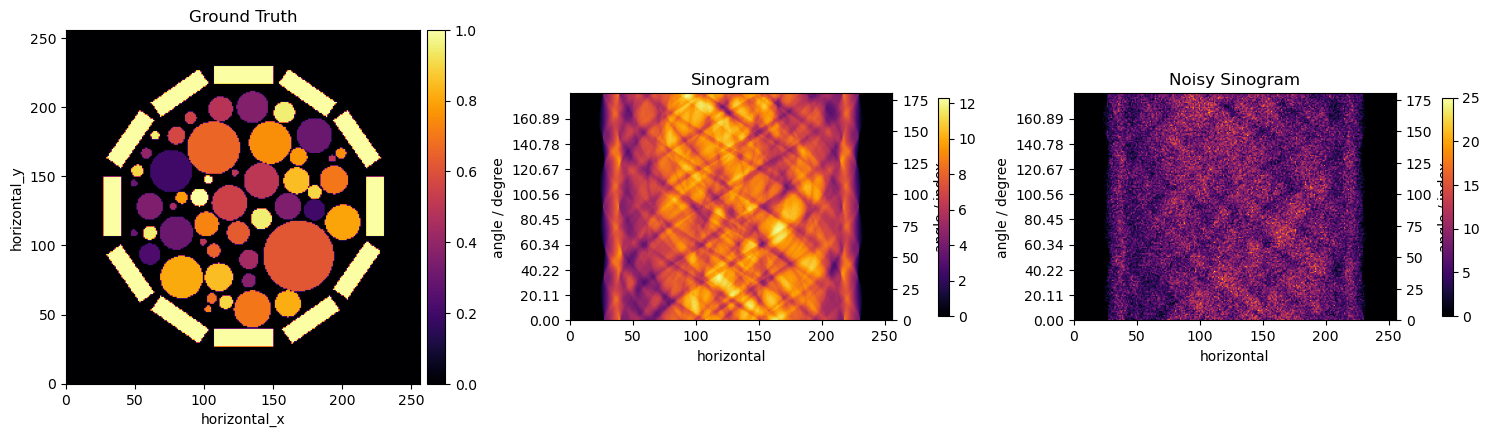

Saved image as e:\天天\undergraduate\3rd year\Project\Poisson noise.png


<Figure size 640x480 with 0 Axes>

In [33]:
# Simulate Poisson noise for the sinogram
noisy_sino1 = ag.allocate()
noisy_sino1.fill(np.random.poisson(sino.array))
noisy_sino1.array[noisy_sino1.array<0]=0

# Show numerical and noisy sinograms
Poissonnoise = show2D([phantom, sino, noisy_sino1], title=['Ground Truth', 'Sinogram', 'Noisy Sinogram'], num_cols=3, cmap='inferno')
Poissonnoise.save('Poisson noise.png')

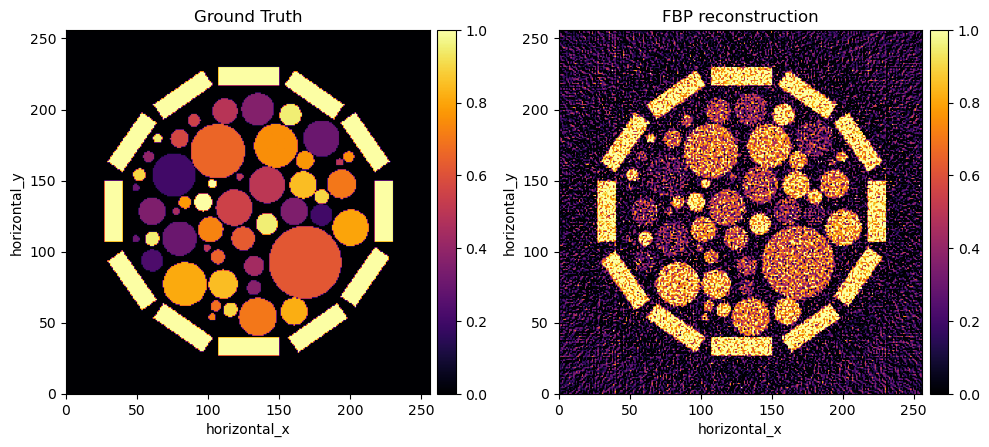

In [34]:
# Setup and run the FBP algorithm
fbp_recon = FBP(ig, ag,  device = 'cpu')(noisy_sino)

# Show reconstructions
show2D([phantom, fbp_recon], 
       title = ['Ground Truth','FBP reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))

In [35]:
# Define BlockOperator K
Grad = GradientOperator(ig)
K = BlockOperator(A, Grad)

# Define BlockFunction f
alpha = 0.1
f1 = 0.5 * L2NormSquared(b=noisy_sino)
f2 = alpha * MixedL21Norm()
f = BlockFunction(f1, f2)

# Define Function g
g = IndicatorBox(lower=0)

# Primal/Dual stepsizes
normK = K.norm()
sigma = 1./normK
tau = 1./normK

# Setup and run PDHG
pdhg = PDHG(f = f, g = g, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 200,
            update_objective_interval = 50)
pdhg.run(verbose=2)

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    1.03545e+06  -0.00000e+00    1.03545e+06
       50        200         0.166    8.43840e+03   6.80308e+03    1.63532e+03
      100        200         0.158    7.64937e+03   7.68728e+03   -3.79188e+01
      150        200         0.155    7.56313e+03   7.49333e+03    6.98018e+01
      200        200         0.155    7.54432e+03   7.52929e+03    1.50245e+01
----------------------------------------------------------------------------
      200        200         0.155    7.54432e+03   7.52929e+03    1.50245e+01
Stop criterion has been reached.



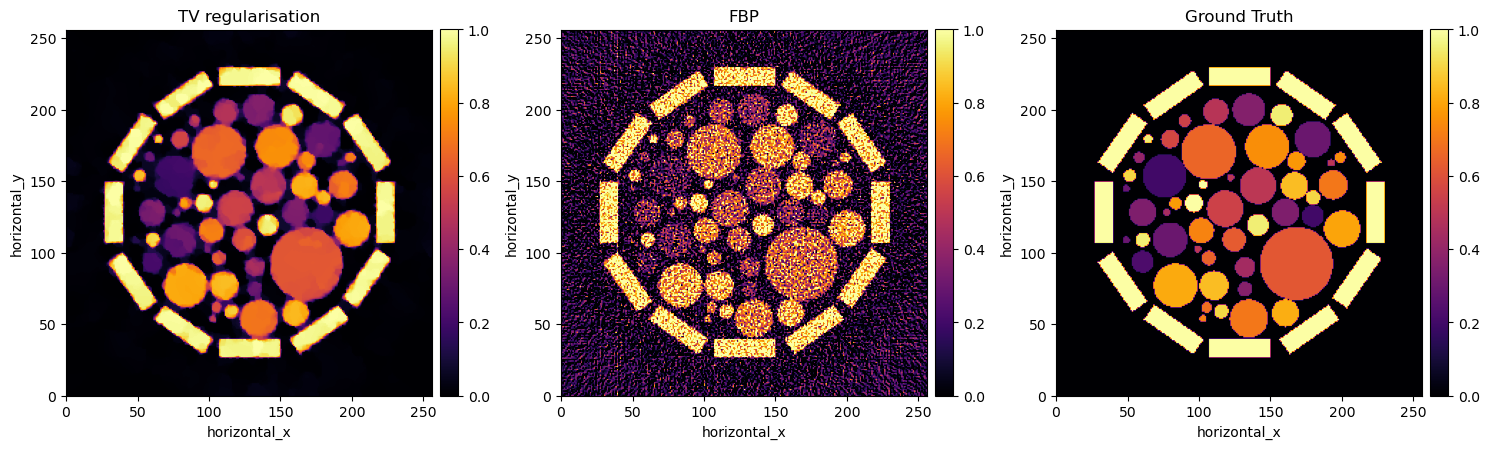

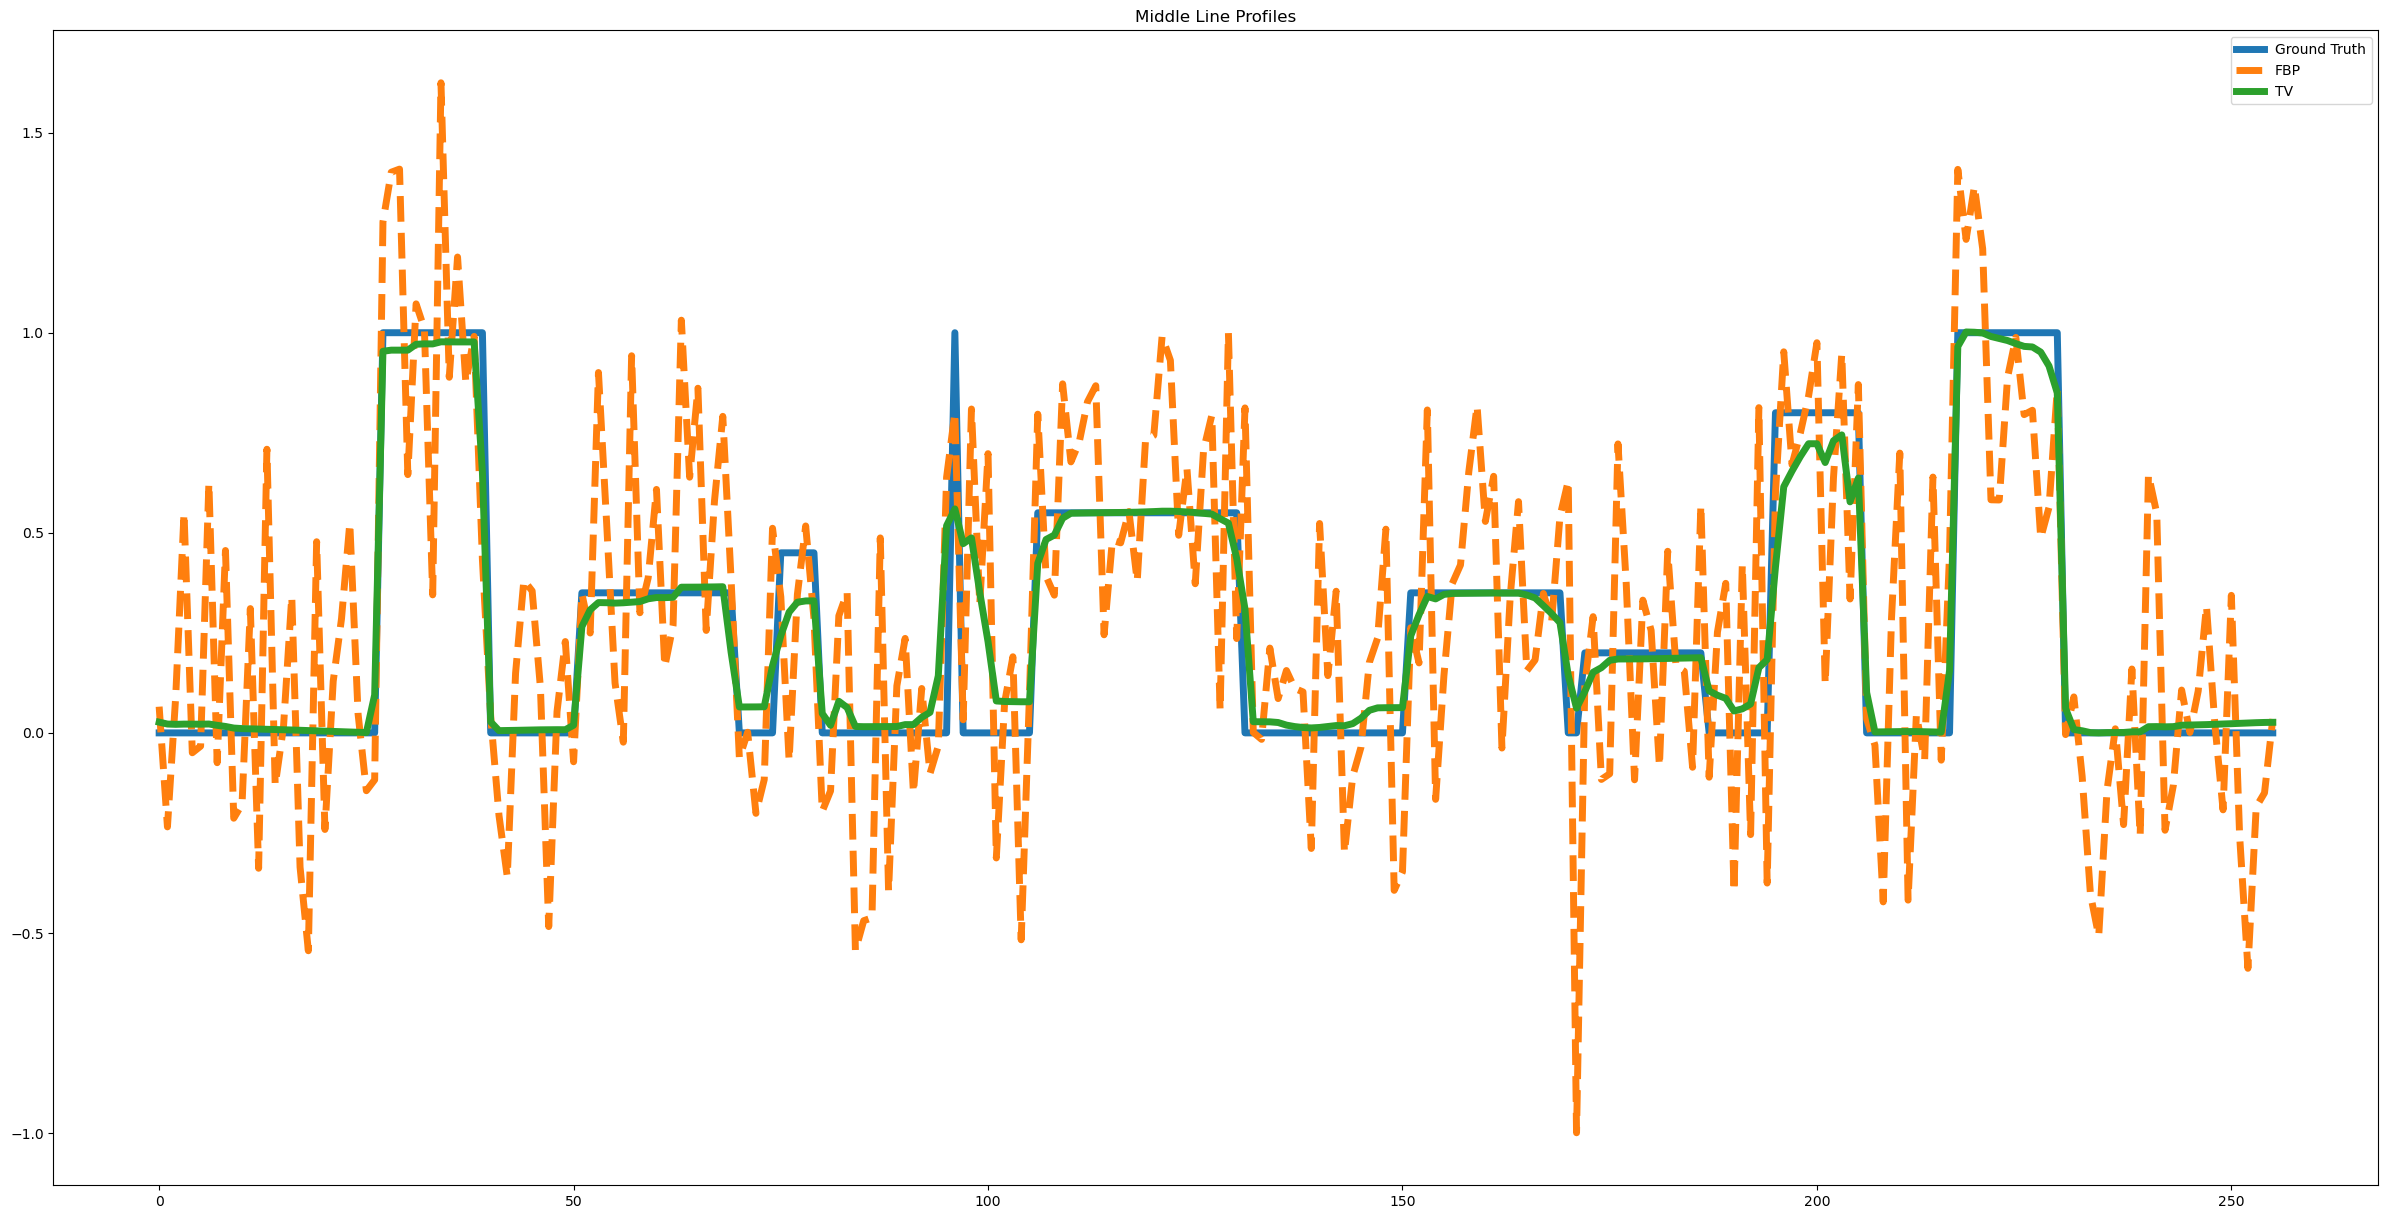

In [36]:
show2D([pdhg.solution,fbp_recon, phantom], title = ['TV regularisation','FBP','Ground Truth'], cmap = 'inferno', num_cols=3, fix_range=(0,1.))

# Plot middle line profile
plt.figure(figsize=(30,15))
plt.plot(phantom.get_slice(horizontal_y = int(N/2)).as_array(), label = 'Ground Truth', linewidth=5)
plt.plot(fbp_recon.get_slice(horizontal_y = int(N/2)).as_array(), label = 'FBP', linewidth=5, linestyle='dashed')
plt.plot(pdhg.solution.get_slice(horizontal_y = int(N/2)).as_array(), label = 'TV', linewidth=5)
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

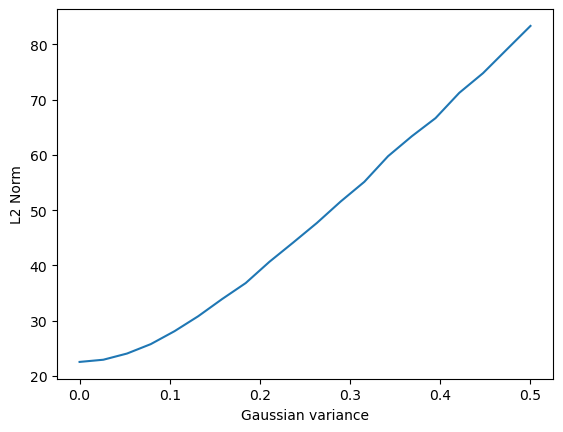

In [37]:
gaussian_mean = 0
gaussian_variance = np.linspace(0, 0.5, 20)
L2Norm = []


for gaussian_vars in gaussian_variance:
      n11 = np.random.normal(gaussian_mean, gaussian_vars, size = ag.shape)
    
      noisy_sino1 = ag.allocate()
      noisy_sino1.fill(n11 + sino.array)
      noisy_sino1.array[noisy_sino.array<0]=0
    
      fbp_recon1 = FBP(ig, ag,  device = 'cpu')(noisy_sino1)
    
      L2squared = L2NormSquared(b = phantom)
      L2 = L2squared(fbp_recon1)**(1/2)
      L2Norm.append(L2)
      
plt.plot(gaussian_variance,L2Norm)
plt.xlabel("Gaussian variance")
plt.ylabel("L2 Norm")

plt.savefig('l2gaussvarfbp.png')
plt.show()

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    1.03064e+06  -0.00000e+00    1.03064e+06
       50        200         0.137    3.68305e+03   2.90866e+03    7.74393e+02
      100        200         0.143    2.91254e+03   3.02006e+03   -1.07516e+02
      150        200         0.146    2.83189e+03   2.75985e+03    7.20362e+01
      200        200         0.150    2.81206e+03   2.80001e+03    1.20477e+01
----------------------------------------------------------------------------
      200        200         0.150    2.81206e+03   2.80001e+03    1.20477e+01
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    1.03097e+06  -0.00000e+00    1.03097e+06
       50        200

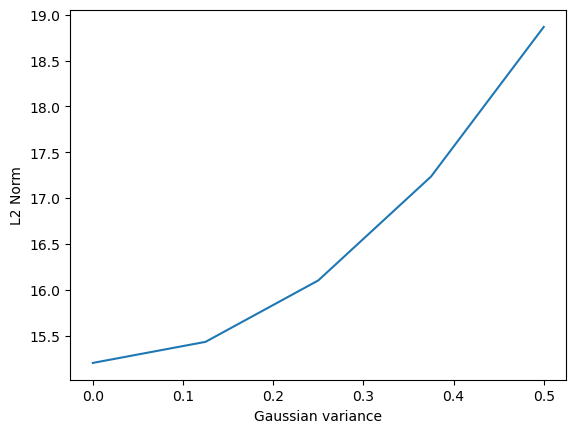

In [38]:
gaussian_mean = 0
gaussian_variance = np.linspace(0,0.5,5)
L2Norm = []


for gaussian_vars in gaussian_variance:
      n12 = np.random.normal(gaussian_mean, gaussian_vars, size = ag.shape)
      
      noisy_sino2 = ag.allocate()
      noisy_sino2.fill(n12 + sino.array)
      noisy_sino2.array[noisy_sino.array<0]=0
      
      alpha = 0.1
      f11 = 0.5 * L2NormSquared(b=noisy_sino2)
      f21 = alpha * MixedL21Norm()
      f1 = BlockFunction(f11, f21)

      g1 = IndicatorBox(lower=0)

      normK = K.norm()
      sigma = 1./normK
      tau = 1./normK
      
      pdhg1 = PDHG(f = f1, g = g1, operator = K, sigma = sigma, tau = tau, 
             max_iteration = 200,
             update_objective_interval = 50)
      pdhg1.run(verbose=2)
      
      L2squared = L2NormSquared(b = phantom)
      L2 = L2squared(pdhg1.solution)**(1/2)
      L2Norm.append(L2)
      
plt.plot(gaussian_variance,L2Norm)
plt.xlabel("Gaussian variance")
plt.ylabel("L2 Norm")

plt.savefig('l2gaussvarpdhg.png')
plt.show()

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    1.03064e+06  -0.00000e+00    1.03064e+06
       50        200         0.153    3.68305e+03   2.90866e+03    7.74393e+02
      100        200         0.156    2.91254e+03   3.02006e+03   -1.07516e+02
      150        200         0.158    2.83189e+03   2.75985e+03    7.20362e+01
      200        200         0.159    2.81206e+03   2.80001e+03    1.20477e+01
----------------------------------------------------------------------------
      200        200         0.159    2.81206e+03   2.80001e+03    1.20477e+01
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    1.03082e+06  -0.00000e+00    1.03082e+06
       50        200

<function matplotlib.pyplot.show(close=None, block=None)>

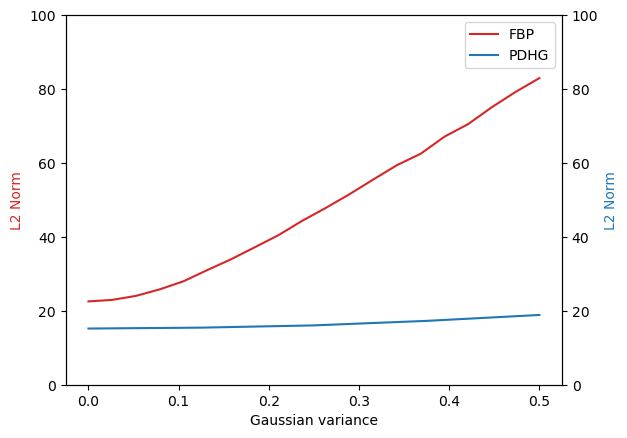

In [39]:
gaussian_mean = 0
gaussian_variance = np.linspace(0, 0.5, 20)
L2Norm = []


for gaussian_vars in gaussian_variance:
      n11 = np.random.normal(gaussian_mean, gaussian_vars, size = ag.shape)
    
      noisy_sino1 = ag.allocate()
      noisy_sino1.fill(n11 + sino.array)
      noisy_sino1.array[noisy_sino.array<0]=0
    
      fbp_recon1 = FBP(ig, ag,  device = 'cpu')(noisy_sino1)
    
      L2squared = L2NormSquared(b = phantom)
      L2 = L2squared(fbp_recon1)**(1/2)
      L2Norm.append(L2)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("Gaussian variance")
ax1.set_ylabel("L2 Norm", color = color)
lns1 = ax1.plot(gaussian_variance, L2Norm, color = color, label = "FBP")


gaussian_mean = 0
gaussian_variance = np.linspace(0,0.5,5)
L2Norm = []


for gaussian_vars in gaussian_variance:
      n12 = np.random.normal(gaussian_mean, gaussian_vars, size = ag.shape)
      
      noisy_sino2 = ag.allocate()
      noisy_sino2.fill(n12 + sino.array)
      noisy_sino2.array[noisy_sino.array<0]=0
      
      alpha = 0.1
      f11 = 0.5 * L2NormSquared(b=noisy_sino2)
      f21 = alpha * MixedL21Norm()
      f1 = BlockFunction(f11, f21)

      g1 = IndicatorBox(lower=0)

      normK = K.norm()
      sigma = 1./normK
      tau = 1./normK
      
      pdhg1 = PDHG(f = f1, g = g1, operator = K, sigma = sigma, tau = tau, 
             max_iteration = 200,
             update_objective_interval = 50)
      pdhg1.run(verbose=2)
      
      L2squared = L2NormSquared(b = phantom)
      L2 = L2squared(pdhg1.solution)**(1/2)
      L2Norm.append(L2)
      
ax2 = ax1.twinx()

a, b = 0, 100
ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

color = 'tab:blue'
ax2.set_ylabel("L2 Norm", color = color)
lns2 = ax2.plot(gaussian_variance, L2Norm, color = color, label = "PDHG")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc = 0)

plt.savefig('l2gaussianvar.png')
plt.show